#Connection to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import relevant modules

In [ ]:
import scipy.io as sio
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from torchvision import datasets, models, transforms

import numpy as np

from PIL import Image
from PIL import ImageStat

import matplotlib.pyplot as plt

import time
import os
import shutil
import random

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix

import seaborn as sn

# Check device

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.7.0+cu101
True
Tesla T4
cuda:0


# Path definition


In [ ]:
path_drive = '/content/gdrive/MyDrive/Data Mining'
path_test_kaggle = path_drive + '/Test_Kaggle'
path_dataset = path_drive + '/Dataset'
path_dataset_clean = path_dataset + '/Clean'
path_dataset_adversarial = path_dataset + '/Adversarial'
path_validation = path_drive + '/Validation'
path_validation_clean = path_validation + '/Clean'
path_validation_adversarial = path_validation + '/Adversarial'
path_train = path_drive + '/Train'
path_train_clean = path_train + '/Clean'
path_train_adversarial = path_train + '/Adversarial'
path_trainval = path_drive + '/TrainVal'
path_trainval_clean = path_trainval + '/Clean'
path_trainval_adversarial = path_trainval + '/Adversarial'
path_test = path_drive + '/Test'
path_test_clean = path_test + '/Clean'
path_test_adversarial = path_test + '/Adversarial'
path_out = path_drive + '/Output'

# Check dataset

In [ ]:
# Clean fingerprints
wrong_num_img = False
print('Clean fingerprints:')
subjects = os.listdir(path_dataset_clean)
print('\t' + 'Number of subjects:', len(subjects))
for subj in subjects:
  images = os.listdir(os.path.join(path_dataset_clean, subj))
  if len(images) != 10:
    wrong_num_img = True
    print('Error in folder', subj, 'wrong image number.')

if not wrong_num_img:
    print('\t' + 'Number of images per subject: 10')
    print('\t' + 'Total number of images:', 10*len(subjects))
else:
  raise ValueError  

# Adversarial fingerprints
wrong_num_img = False
print('Adversarial fingerprints:')
subjects = os.listdir(path_dataset_adversarial)
print('\t' + 'Number of subjects:', len(subjects))
for subj in subjects:
  images = os.listdir(os.path.join(path_dataset_adversarial, subj))
  if len(images) != 10:
    wrong_num_img = True
    print('Error in folder', subj, 'wrong image number.')


if not wrong_num_img:
    print('\t' + 'Number of images per subject: 10')
    print('\t' + 'Total number of images:', 10*len(subjects))
else:
  raise ValueError  

# Test fingerprints
wrong_num_img = False
print('Test fingerprints:')
images = os.listdir(path_test_kaggle)
print('\t' + 'Total number of images:', len(images))

if len(images) != 1200:
  raise ValueError  

Clean fingerprints:
	Number of subjects: 190
	Number of images per subject: 10
	Total number of images: 1900
Adversarial fingerprints:
	Number of subjects: 182
	Number of images per subject: 10
	Total number of images: 1820
Test fingerprints:
	Total number of images: 1200


# Splitting dataset



In [ ]:
ratio_validation = 0.3
ratio_train_val = 0.8

subjects_clean = os.listdir(path_dataset_clean)
print('Clean subjects: ', len(subjects_clean))

subjects_adv = os.listdir(path_dataset_adversarial)
print('Adversarial subjects: ', len(subjects_adv))

excluded = [s for s in subjects_clean if s not in subjects_adv]

subjects = subjects_adv.copy()

samples_train_val = np.random.choice(subjects, round(ratio_train_val*len(subjects)), replace=False)
samples_val = list(np.random.choice(samples_train_val, round(ratio_validation*len(samples_train_val)), replace=False))
samples_train = [s for s in samples_train_val if s not in samples_val]
samples_test = [s for s in subjects if s not in samples_train_val]


print('Training subjects: ', len(samples_train))
print('Validation subjects: ', len(samples_val))
print('Test subjects: ', len(samples_test))
print('Excluded subjects: ', excluded)

try:
  os.mkdir(path_validation)
  os.mkdir(path_validation_clean)
  os.mkdir(path_validation_adversarial)

  os.mkdir(path_train)
  os.mkdir(path_train_clean)
  os.mkdir(path_train_adversarial)

  os.mkdir(path_test)
  os.mkdir(path_test_clean)
  os.mkdir(path_test_adversarial)

  # Clean data

  for subject in samples_val: 
    path_folder = path_validation_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)

  for subject in samples_train:
    path_folder = path_train_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder) 

  for subject in samples_test:
    path_folder = path_test_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)

  # Adversarial data

  for subject in samples_val:
    path_folder = path_validation_adversarial + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_adversarial + '/' + subject):
      path_img = path_dataset_adversarial + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)
  
  for subject in samples_train:
    path_folder = path_train_adversarial + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_adversarial + '/' + subject):
      path_img = path_dataset_adversarial + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder) 

  for subject in samples_test:
    path_folder = path_test_adversarial + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_adversarial + '/' + subject):
      path_img = path_dataset_adversarial + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)

  include_train = excluded[0:4]
  include_val = excluded[4:6]
  include_test = excluded[6:8]

  for subject in include_train:
    path_folder = path_train_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder) 


  for subject in include_val:
    path_folder = path_validation_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)

  for subject in include_test:
    path_folder = path_test_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)
    
  print('Partitions created')

except FileExistsError:
  print('Direcotry aready exists')

Clean subjects:  190
Adversarial subjects:  182
Training subjects:  102
Validation subjects:  44
Test subjects:  36
Excluded subjects:  ['subject_139', 'subject_133', 'subject_136', 'subject_148', 'subject_151', 'subject_169', 'subject_166', 'subject_181']
Direcotry aready exists


In [ ]:
# Create TrainVal folder

try:
  os.mkdir(path_trainval)
  os.mkdir(path_trainval_clean)
  os.mkdir(path_trainval_adversarial)

  subjects_clean = os.listdir(path_train_clean) + os.listdir(path_validation_clean)
  print('Clean subjects: ', len(subjects_clean))

  subjects_adv = os.listdir(path_train_adversarial) + os.listdir(path_validation_adversarial)
  print('Adversarial subjects: ', len(subjects_adv))

  for subject in subjects_clean: 
    path_folder = path_trainval_clean + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_clean + '/' + subject):
      path_img = path_dataset_clean + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)
  
  for subject in subjects_adv: 
    path_folder = path_trainval_adversarial + '/' + subject
    os.mkdir(path_folder)
    for elem in os.listdir(path_dataset_adversarial + '/' + subject):
      path_img = path_dataset_adversarial + '/' + subject + '/' + elem
      shutil.copy(path_img, path_folder)

except FileExistsError:
  print('Direcotry aready exists')

Clean subjects:  152
Adversarial subjects:  146


# Functions 


## Training and Validation function

In [ ]:
def train_model(dataloader_train, dataloader_test, start_epoch, num_epochs, model, loss_function, optimizer, scheduler,
                          best_acc, best_loss, best_epoch, path_out):
 
  model.cuda()

  # For each epoch
  for epochs in tqdm(range(start_epoch, num_epochs + 1), desc='Loop epochs'):
    since = time.time()
    
    model_loss_train = 0.0
    model_acc_train = 0.0
    total_size_train = 0
    
    model.train() 

    # For each batch
    for inputs, labels in dataloader_train:
      inputs = inputs.type(torch.FloatTensor).cuda()   
      labels = labels.cuda()
      
      optimizer.zero_grad()
      model.zero_grad()

      y = model(inputs)

      loss = loss_function(y, labels)

      pred = torch.log_softmax(y, dim=1)  
      _, preds = torch.max(pred, dim = 1)
    
      model_loss_train += loss.item() * inputs.size(0)
      total_size_train += inputs.size(0)
      model_acc_train += torch.sum(preds == labels).item()

      loss.backward()  
      optimizer.step()
    
    if scheduler:
      scheduler.step()
    else:
      if (epochs - best_epoch)%20 == 0 and dataloader_test != False:
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*0.1
        print('Adjusting learning rate to', optimizer.param_groups[0]['lr'])

    model_loss_epoch_train = model_loss_train/total_size_train
    model_acc_epoch_train  = model_acc_train/total_size_train
    
    torch.save(model.state_dict(), os.path.join(path_out, 'train_weights.pth'))

    if dataloader_test != False: 
      model.eval()

      total_size_val = 0
      model_loss_val = 0.0
      model_acc_val = 0.0

      for inputs, labels in dataloader_test:
        inputs = inputs.type(torch.FloatTensor).cuda()    
        labels = labels.cuda()
            
        y = model(inputs)

        loss = loss_function(y, labels)
        
        pred = torch.log_softmax(y, dim=1)  
        _, preds = torch.max(pred, dim = 1)

        model_loss_val += loss.item() * inputs.size(0)
        total_size_val += inputs.size(0)
        model_acc_val += torch.sum(preds == labels).item()
          
            
      model_loss_epoch_val = model_loss_val/total_size_val
      model_acc_epoch_val = model_acc_val/total_size_val

    elapsed = time.time() - since

    if dataloader_test != False:
      print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][VAL on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
            %(epochs, total_size_train, model_loss_epoch_train, model_acc_epoch_train, total_size_val, model_loss_epoch_val, 
              model_acc_epoch_val, elapsed // 60, elapsed % 60))
      
      
      if (model_acc_epoch_val > best_acc) or (model_acc_epoch_val == best_acc and model_loss_epoch_val < best_loss):
        print('\t.... Saving best weights ....')
        best_acc = model_acc_epoch_val
        best_loss = model_loss_epoch_val
        best_epoch = epochs
        
        torch.save(model.state_dict(), os.path.join(path_out, 'best_model_weights.pth'))

      with open(os.path.join(path_out, 'lossVal.txt'), 'a') as f:
        f.write(str(model_loss_epoch_val) + '\n')
        
      with open(os.path.join(path_out, 'accVal.txt'), 'a') as f:
        f.write(str(model_acc_epoch_val) + '\n')
        
    else:
      print('[Epoch %d][TRAIN on %d [Loss: %.4f  ACC: %.4f]][TIME: %.0f m %.0f s]' 
            %(epochs, total_size_train, model_loss_epoch_train, model_acc_epoch_train, elapsed // 60, elapsed % 60))
       
    with open(os.path.join(path_out, 'lossTrain.txt'), 'a') as f:
      f.write(str(model_loss_epoch_train) + '\n')
        
    with open(os.path.join(path_out, 'accTrain.txt'), 'a') as f:
      f.write(str(model_acc_epoch_train) + '\n')
      
    dict_checkpoint = {'best_acc': best_acc, 
                      'best_loss': best_loss,
                      'best_epoch': best_epoch,
                      'last_epoch': epochs} 

    df_checkpoint = pd.DataFrame(data=dict_checkpoint, index=[0])
    df_checkpoint.to_csv(os.path.join(path_out, 'check_point.csv'))

    if epochs%10 == 0 or epochs == (num_epochs + 1):
      print_graphs()
  print_graphs()

## Print graph function

In [ ]:
def print_graphs():
  loss_model_train = []
  loss_model_val = []
  acc_model_train = []
  acc_model_val = []

  with open(os.path.join(path_out, 'lossTrain.txt'), 'r') as f:
    lines = f.readlines()
    for line in lines:
      loss_model_train.append(float(line))

  with open(os.path.join(path_out, 'accTrain.txt'), 'r') as f:
    lines = f.readlines()
    for line in lines:
      acc_model_train.append(float(line))


  if os.path.isfile(os.path.join(path_out, 'accVal.txt')):
    with open(os.path.join(path_out, 'lossVal.txt'), 'r') as f:
      lines = f.readlines()
      for line in lines:
        loss_model_val.append(float(line))

    with open(os.path.join(path_out, 'accVal.txt'), 'r') as f:
      lines = f.readlines()
      for line in lines:
        acc_model_val.append(float(line))

    figure = plt.figure()
    plt.title('Model: Training Vs Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(list(range(1,len(loss_model_train)+1)), loss_model_train, color='r', label='Training Loss')
    plt.plot(list(range(1, len(loss_model_val)+1)), loss_model_val, color='g', label='Validation Loss')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, len(loss_model_train)+1, round((len(loss_model_train)+1)/10)))
    plt.savefig(os.path.join(path_out, 'LossTrainVal.png'))
    plt.close(fig=figure)
    # plt.show()

    figure = plt.figure()
    plt.title('Training Vs Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(list(range(1, len(acc_model_train)+1)), acc_model_train, color='r', label='Training Accuracy')
    plt.plot(list(range(1, len(acc_model_val)+1)), acc_model_val, color='g', label='Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, len(acc_model_train)+1, round((len(acc_model_train)+1)/10)))
    plt.savefig(os.path.join(path_out, 'AccTrainVal.png'))
    plt.close(fig=figure)
    # plt.show()
  else:
    figure = plt.figure()
    plt.title('Model: Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(list(range(1,len(loss_model_train)+1)), loss_model_train, color='r', label='Training Loss')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, len(loss_model_train)+1, round((len(loss_model_train)+1)/10)))
    plt.savefig(os.path.join(path_out, 'LossTrain.png'))
    plt.close(fig=figure)
    # plt.show()

    figure = plt.figure()
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(list(range(1, len(acc_model_train)+1)), acc_model_train, color='r', label='Training Accuracy')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, len(acc_model_train)+1, round((len(acc_model_train)+1)/10)))
    plt.savefig(os.path.join(path_out, 'AccTrain.png'))
    plt.close(fig=figure)
    # plt.show()

# Data analysis


In [ ]:
# Check size

diff_size = False

subjects = os.listdir(path_dataset_clean)
for subj in subjects:
  for image in os.listdir(os.path.join(path_dataset_clean, subj)):
    img = Image.open(os.path.join(path_dataset_clean, subj, image))
    if img.size != (252,324):
      diff_size = True
      print(img.size)


subjects = os.listdir(path_dataset_adversarial)
for subj in subjects:
  for image in os.listdir(os.path.join(path_dataset_adversarial, subj)):
    img = Image.open(os.path.join(path_dataset_adversarial, subj, image))
    if img.size != (252,324):
      diff_size = True
      print(img.size)

if not diff_size:
  print('Image size:', img.size)

Image size: (252, 324)


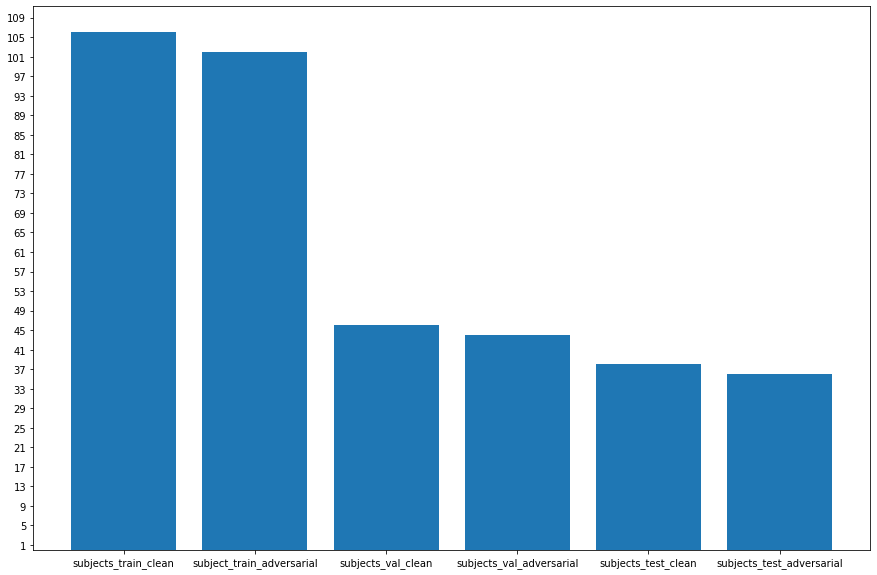

In [ ]:
# Data distribution among dataset partitions

subjects_clean = len(os.listdir(path_dataset_clean))
subjects_adversarial = len(os.listdir(path_dataset_adversarial))

subjects_train_clean = len(os.listdir(path_train_clean))
subject_train_adversarial = len(os.listdir(path_train_adversarial))
subjects_val_clean = len(os.listdir(path_validation_clean))
subjects_val_adversarial = len(os.listdir(path_validation_adversarial))
subjects_test_clean = len(os.listdir(path_test_clean))
subjects_test_adversarial = len(os.listdir(path_test_adversarial))

fig = plt.figure(figsize=(15,10))
plt.yticks(ticks=np.arange(1,120,4))
labels = ['subjects_train_clean','subject_train_adversarial', 'subjects_val_clean', 'subjects_val_adversarial', 'subjects_test_clean', 'subjects_test_adversarial']
data = [subjects_train_clean, subject_train_adversarial, subjects_val_clean, subjects_val_adversarial, subjects_test_clean, subjects_test_adversarial]
plt.bar(x=labels, height=data)
plt.savefig(os.path.join(path_drive, 'Distribuzione dati.png'))
plt.show()

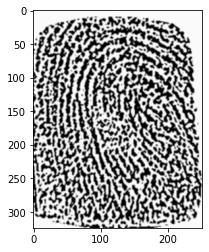

In [ ]:
img = Image.open('/content/gdrive/MyDrive/Data Mining/Train/Adversarial/subject_100/fingerprint_1.png')

plt.imshow(img)
plt.show()

# Model definition


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## VGG19


In [ ]:
# VGG19

data_transforms = {
    'Train': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.RandomHorizontalFlip(0.5),
                                 transforms.RandomVerticalFlip(0.5),
                                 transforms.RandomRotation((0,360),fill=(255,255,255)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'Validation': transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                   }


img_datasets = {x : datasets.ImageFolder(os.path.join(path_drive, x), data_transforms[x]) for x in ['Train', 'Validation']}
dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size=parameters['batch_size'], shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

size_training = len(img_datasets['Train'])
size_validation = len(img_datasets['Validation'])

print('Number of fingerprints in training set:', size_training)
print('Number of fingerprints in validation set:', size_validation)

vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, 2)

for elem in vgg19.parameters():
  elem.requires_grad = False

for elem in vgg19.classifier.parameters():
  elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=parameters['learning_rate'])
model = vgg19

## VGG19_bn


In [ ]:
# VGG19_bn

parameters = {'learning_rate' : 0.00003,
              'batch_size' : 32,
              'num_epochs' : 500}


data_transforms = {
    'Train': transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                # transforms.RandomVerticalFlip(0.5),
                                #  transforms.RandomAffine(degrees=15, translate=(0.05,0.05), scale=(0.8,1), 
                                #                          fillcolor=(round(0.9804*255),round(0.9804*255),round(0.9804*255))),
                                #  transforms.ColorJitter(brightness=(1,5), contrast=20, saturation=100),
                                #  transforms.GaussianBlur(1,(1,2)),
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ]),
    'Validation': transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                   }

img_datasets = {x : datasets.ImageFolder(os.path.join(path_drive, x), data_transforms[x]) for x in ['Train', 'Validation']}
dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size=parameters['batch_size'], shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

size_training = len(img_datasets['Train'])
size_validation = len(img_datasets['Validation'])

print('Number of fingerprints in training set:', size_training)
print('Number of fingerprints in validation set:', size_validation)

vgg19_bn = models.vgg19_bn(pretrained=True)
# vgg19_bn.classifier[6] = nn.Linear(4096, 1) 
# vgg19_bn.classifier[6] = nn.Sigmoid()

class_layers = list(vgg19_bn.classifier.children())[:-1]  # Remove last layer
class_layers.extend([nn.Linear(4096, 2)])                 # Add layers
vgg19_bn.classifier = nn.Sequential(*class_layers)        # Replace the model classifier

for elem in vgg19_bn.parameters():
  elem.requires_grad = True

# for elem in vgg19_bn.classifier.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_bn.parameters(), lr=parameters['learning_rate']) # <--------------------------------------------- CAMBIARE SE NON FINE TUNING!!!
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
model = vgg19_bn

Number of fingerprints in training set: 2080
Number of fingerprints in validation set: 900


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


## AlexNet


In [ ]:
# AlexNet

parameters = {'learning_rate' : 0.0001,
              'lr_step_size' : 0,
              'lr_decay' : 0,
              'weight_decay' : 0.03,
              'batch_size' : 32,
              'num_epochs' : 500}


data_transforms = {
    'Train': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.RandomHorizontalFlip(0.5),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                  ]),
    'Validation': transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                   }


img_datasets = {x : datasets.ImageFolder(os.path.join(path_drive, x), data_transforms[x]) for x in ['Train', 'Validation']}
dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size=parameters['batch_size'], shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

size_training = len(img_datasets['Train'])
size_validation = len(img_datasets['Validation'])

print('Number of fingerprints in training set:', size_training)
print('Number of fingerprints in validation set:', size_validation)

alexnet = models.alexnet(pretrained=True)

class_layers = list(alexnet.classifier.children())[:-1]
class_layers.extend([nn.Linear(4096, 2)])       
alexnet.classifier = nn.Sequential(*class_layers)     

for elem in alexnet.parameters():
  elem.requires_grad = True

# for elem in alexnet.classifier.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay']) # <--------------------------------------------- 
# scheduler = optim.lr_scheduler.StepLR(optimizer, parameters['lr_step_size'], gamma=parameters['lr_decay'], last_epoch=-1, verbose=False) # <--- PROVARE
scheduler = False

model = alexnet

Number of fingerprints in training set: 2080
Number of fingerprints in validation set: 900


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


## ResNet50


In [ ]:
# ResNet50

parameters = {'learning_rate' : 0.00005,
              'batch_size' : 32,
              'num_epochs' : 500}


data_transforms = {
    'Train': transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                  # transforms.RandomVerticalFlip(0.5),
                                  transforms.RandomAffine(degrees=10, translate=(0.01,0.01)), # <----------- Valutare aggiunta del riscalamento
                                  # transforms.FiveCrop(size=(224,224)),
                                  # transforms.Lambda(lambda crops: [crop for crop in crops][np.random.randint(0,5)]),
                                  # transforms.ColorJitter(contrast=10),
                                  # transforms.GaussianBlur(5,1),
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                  ]),
    'Validation': transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                   }


img_datasets = {x : datasets.ImageFolder(os.path.join(path_drive, x), data_transforms[x]) for x in ['Train', 'Validation']}
dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size=parameters['batch_size'], shuffle=True, num_workers=4) for x in ['Train', 'Validation']}

size_training = len(img_datasets['Train'])
size_validation = len(img_datasets['Validation'])

print('Number of fingerprints in training set:', size_training)
print('Number of fingerprints in validation set:', size_validation)

resnet50 = models.resnet50(pretrained=True)

class_layers = list(resnet50.fc.children())[:-1]
class_layers.extend([nn.Linear(2048, 2)])       
resnet50.fc = nn.Sequential(*class_layers)     

for elem in resnet50.parameters():
  elem.requires_grad = True

# for elem in resnet50.fc.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=parameters['learning_rate']) # <--------------------------------------------- 
model = resnet50

Number of fingerprints in training set: 2080
Number of fingerprints in validation set: 900


## Model training

In [ ]:
# Save settings

try:
  os.mkdir(path_out)
  print('Output folder created at:', path_out)

  col = ['model', 'pretrained', 'fine_tuning', 'optimizer', 'scheduler', 'scheduler_par', 'loss_function', 'learning_rate', 'weight_decay', 'batch_size', 'num_epochs', 'data_augmentation']
  data = [['AlexNet', True, False, 'Adam(model, lr)', scheduler, {'lr_step_size' : parameters['lr_step_size'], 'lr_decay' : parameters['lr_decay']}, 'CrossEntropyLoss()', parameters['learning_rate'], parameters['weight_decay'], parameters['batch_size'], parameters['num_epochs'], data_transforms]]
  df_settings = pd.DataFrame(columns=col, data=data)

  df_settings.to_csv(os.path.join(path_out, 'settings.csv'))
  
except FileExistsError:
  print('Output directory already exists')

Output folder created at: /content/gdrive/MyDrive/Data Mining/Output


In [ ]:
# Train model

previous_model = os.path.join(path_out, 'train_weights.pth')
if os.path.isfile(previous_model):
  print('Previous model weights found, would you like to load them? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading weights...')
    model.load_state_dict(torch.load(previous_model)) 
else:
  print('No previous model weights found')
  
previous_checkpoint = os.path.join(path_out, 'check_point.csv')
if os.path.isfile(previous_checkpoint):
  print('Previous checkpoint found, would you like to load it? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading parameters...')
    df_checkpoint = pd.read_csv(previous_checkpoint)
    best_acc = df_checkpoint['best_acc'][0]
    best_loss = df_checkpoint['best_loss'][0]
    best_epoch = df_checkpoint['best_epoch'][0]
    start_epoch = df_checkpoint['last_epoch'][0] + 1
  else:
    start_epoch = 1
    best_acc = 0
    best_loss= 0
    best_epoch = 0

else:
  start_epoch = 1
  best_acc = 0
  best_loss= 0
  best_epoch = 0
  print('No previous checkpoint found')

train_model(dataloaders['Train'], dataloaders['Validation'], start_epoch, parameters['num_epochs'], model, loss_function, optimizer, scheduler, best_acc, best_loss, best_epoch, path_out)

# Model evaluation


## Retrain model on train and validation sets


In [ ]:
df_best = pd.read_csv(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'check_point.csv'), index_col=0)
df_best_settings = pd.read_csv(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'settings.csv'), index_col=0)

lr = float(df_best_settings['learning_rate'][0])
bs = int(df_best_settings['batch_size'][0])
num_epochs = int(df_best['best_epoch'][0])

# AlexNet

data_transforms = {
    'TrainVal': transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                  ]),
    'Test': transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                   }


img_datasets = {x : datasets.ImageFolder(os.path.join(path_drive, x), data_transforms[x]) for x in ['TrainVal', 'Test']}
dataloaders = {x : torch.utils.data.DataLoader(img_datasets[x], batch_size=bs, shuffle=True, num_workers=4) for x in ['TrainVal', 'Test']}

size_training_val = len(img_datasets['TrainVal'])
size_test = len(img_datasets['Test'])

print('Number of fingerprints in training-validation set:', size_training_val)
print('Number of fingerprints in test set:', size_test)

alexnet = models.alexnet(pretrained=True)

class_layers = list(alexnet.classifier.children())[:-1]
class_layers.extend([nn.Linear(4096, 2)])       
alexnet.classifier = nn.Sequential(*class_layers)     

for elem in alexnet.parameters():
  elem.requires_grad = True

# for elem in alexnet.classifier.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=lr) # <--------------------------------------------- 
# scheduler = optim.lr_scheduler.StepLR(optimizer, 50, 0.5, last_epoch=-1, verbose=False)
scheduler = False
model = alexnet

137

In [ ]:
try:
  os.mkdir(path_out)
except FileExistsError:
  print('Output Directory already exists.')

In [ ]:
# Model training

previous_model = os.path.join(path_out, 'train_weights.pth')
if os.path.isfile(previous_model):
  print('Previous model weights found, would you like to load them? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading weights...')
    model.load_state_dict(torch.load(previous_model)) 
else:
  print('No previous model weights found')
  
previous_checkpoint = os.path.join(path_out, 'check_point.csv')
if os.path.isfile(previous_checkpoint):
  print('Previous checkpoint found, would you like to load it? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading parameters...')
    df_checkpoint = pd.read_csv(previous_checkpoint)
    best_acc = df_checkpoint['best_acc'][0]
    best_loss = df_checkpoint['best_loss'][0]
    best_epoch = df_checkpoint['best_epoch'][0]
    start_epoch = df_checkpoint['last_epoch'][0] + 1
  else:
    start_epoch = 1
    best_acc = 0
    best_loss= 0
    best_epoch = 0

else:
  start_epoch = 1
  best_acc = 0
  best_loss= 0
  best_epoch = 0
  print('No previous checkpoint found')


train_model(dataloaders['TrainVal'], dataloaders['Test'], start_epoch, num_epochs, model, loss_function, optimizer, scheduler, best_acc, best_loss, best_epoch, path_out)
print_graphs()

In [ ]:
# Model evaluation

data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

img_dataset = datasets.ImageFolder(os.path.join(path_drive, 'Test'), data_transforms)
dataloader = torch.utils.data.DataLoader(img_dataset, batch_size=1, shuffle=False, num_workers=4)

size_test = len(img_dataset)

print('Number of fingerprints in test set:', size_test)

alexnet = models.alexnet(pretrained=True)

class_layers = list(alexnet.classifier.children())[:-1]
class_layers.extend([nn.Linear(4096, 2)])       
alexnet.classifier = nn.Sequential(*class_layers)

alexnet.load_state_dict(torch.load(os.path.join(path_drive, 'Output_AlexNet', 'Output_TrainVal') + '/train_weights.pth'))

# for elem in alexnet.parameters():
#   elem.requires_grad = True

# for elem in alexnet.classifier.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(alexnet.parameters(), lr=lr) # <--------------------------------------------- 
model = alexnet

model.eval()
model.cuda()

model_acc_test = 0.0
total_size_test = 0
model_loss_test = 0
true_labels = []
pred_labels = []

for inp, label in tqdm(dataloader):
  true_labels.append(label.item())
  
  inp = inp.type(torch.FloatTensor).cuda()  
  label = label.cuda()
  y = model(inp)


  loss = loss_function(y, label)

  pred = torch.log_softmax(y, dim=1)  
  _, label_pred = torch.max(pred, dim = 1)
  pred_labels.append(label_pred.item())

  model_loss_test += loss.item()
  total_size_test += 1
  model_acc_test += torch.sum(label_pred == label).item()
    
model_loss_test = model_loss_test/total_size_test
model_acc_test  = model_acc_test/total_size_test

pred_labels = ['Adversarial' if el==0 else 'Clean' for el in pred_labels]
true_labels = ['Adversarial' if el==0 else 'Clean' for el in true_labels]

print('Model accuracy on test set:', model_acc_test)
print('Model loss on test set:', model_loss_test)

Number of fingerprints in test set: 740



Model accuracy on test set: 0.9864864864864865
Model loss on test set: 0.08014080220876807


## Confusion matrix


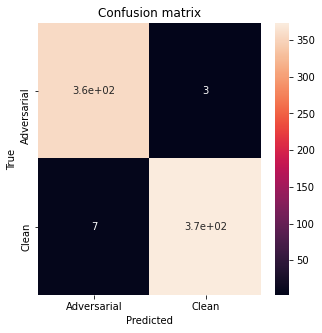

[[357   3]
 [  7 373]]


In [ ]:
labels = ['Adversarial', 'Clean']
from sklearn.metrics import ConfusionMatrixDisplay


c = confusion_matrix(true_labels, pred_labels)

df_cm = pd.DataFrame(c, index = labels, columns = labels)
plt.figure(figsize = (5,5))
ax = plt.axes()
sn.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion matrix')
# plt.savefig(os.path.join(path_drive, 'ConfMatrix.png'))
plt.show()
print(c)

In [ ]:
import numpy as np
from sklearn import metrics

pred_labels_num = [0 if el=='Adversarial' else 1 for el in pred_labels]
true_labels_num = [0 if el=='Adversarial' else 1 for el in true_labels]

fpr, tpr, thresholds = metrics.roc_curve(true_labels_num, pred_labels_num)
print('True positive ratio:', tpr[1])
print('False positive ratio:', fpr[1])

True positive ratio: 0.9815789473684211
False positive ratio: 0.008333333333333333


# Complete training


In [ ]:
df_best = pd.read_csv(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'check_point.csv'), index_col=0)
df_best_settings = pd.read_csv(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'settings.csv'), index_col=0)

lr = float(df_best_settings['learning_rate'][0])
bs = int(df_best_settings['batch_size'][0])
num_epochs = int(df_best['best_epoch'][0])

# AlexNet

data_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                  ])

img_dataset = datasets.ImageFolder(os.path.join(path_drive, 'Dataset'), data_transforms)
dataloader = torch.utils.data.DataLoader(img_dataset, batch_size=bs, shuffle=True, num_workers=4)

size_dataset = len(img_dataset)

print('Number of fingerprints in dataset:', size_dataset)

alexnet = models.alexnet(pretrained=True)

class_layers = list(alexnet.classifier.children())[:-1]
class_layers.extend([nn.Linear(4096, 2)])       
alexnet.classifier = nn.Sequential(*class_layers)     

for elem in alexnet.parameters():
  elem.requires_grad = True

# for elem in alexnet.classifier.parameters():
#   elem.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=lr) # <--------------------------------------------- 
# scheduler = optim.lr_scheduler.StepLR(optimizer, 50, 0.5, last_epoch=-1, verbose=False)
scheduler = False

model = alexnet

Number of fingerprints in dataset: 3720


In [ ]:
try:
  os.mkdir(path_out)
except FileExistsError:
  print('Output Directory already exists.')

In [ ]:
previous_model = os.path.join(path_out, 'train_weights.pth')
if os.path.isfile(previous_model):
  print('Previous model weights found, would you like to load them? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading weights...')
    model.load_state_dict(torch.load(previous_model)) 
else:
  print('No previous model weights found')
  
previous_checkpoint = os.path.join(path_out, 'check_point.csv')
if os.path.isfile(previous_checkpoint):
  print('Previous checkpoint found, would you like to load it? (y/n)')
  resp = input()
  if resp == 'y' or resp == 'Y':
    print('Loading parameters...')
    df_checkpoint = pd.read_csv(previous_checkpoint)
    best_acc = df_checkpoint['best_acc'][0]
    best_loss = df_checkpoint['best_loss'][0]
    best_epoch = df_checkpoint['best_epoch'][0]
    start_epoch = df_checkpoint['last_epoch'][0] + 1
  else:
    start_epoch = 1
    best_acc = 0
    best_loss= 0
    best_epoch = 0

else:
  start_epoch = 1
  best_acc = 0
  best_loss= 0
  best_epoch = 0
  print('No previous checkpoint found')


train_model(dataloader, False, start_epoch, num_epochs, model, loss_function, optimizer, scheduler, best_acc, best_loss, best_epoch, path_out)

# Submission prediction


In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

alexnet = models.alexnet(pretrained=True)

class_layers = list(alexnet.classifier.children())[:-1]
class_layers.extend([nn.Linear(4096, 2)])       
alexnet.classifier = nn.Sequential(*class_layers)

alexnet.load_state_dict(torch.load(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'Output_Complete_Model') + '/train_weights.pth'))

model = alexnet

model.eval()
model.cuda()

dict_pred = {'Fingerprint' : [],
             'Class' : []}

print('Predicting submission images...')

for img_name in tqdm(os.listdir(path_test_kaggle)):
  img = Image.open(os.path.join(path_test_kaggle, img_name))
  img = data_transforms(img).to(device)
  img = img.unsqueeze(0)
  out = model(img)

  pred = torch.log_softmax(out, dim=1)  
  _, label_pred = torch.max(pred, dim = 1)
  dict_pred['Fingerprint'].append(img_name)
  dict_pred['Class'].append(label_pred.item())


df_pred = pd.DataFrame(data = dict_pred)

df_pred = df_pred.replace(0, 'Adversarial')
df_pred = df_pred.replace(1, 'Clean')

df_pred.to_csv(os.path.join(path_drive, 'Output_AlexNet_lr_custom_migliore', 'Output_Complete_Model', 'Submission.csv'), index=False)

df_pred

Predicting submission images...


,Fingerprint,Class
0,testFingerprint_1050.png,Clean
1,testFingerprint_152.png,Adversarial
2,testFingerprint_298.png,Clean
3,testFingerprint_320.png,Adversarial
4,testFingerprint_1163.png,Clean
...,...,...
1195,testFingerprint_138.png,Adversarial
1196,testFingerprint_1178.png,Adversarial
1197,testFingerprint_201.png,Adversarial
1198,testFingerprint_1067.png,Clean
